In [107]:
#загрузим библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

## ПРОЕКТ: Культурист-датасаентист
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что пользователь больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Сеть фитнес-центров разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных.

<br> Задача:провести анализ и подготовить план действий по удержанию клиентов.

Набор данных включает следующие поля:
* 'Churn' — факт оттока в текущем месяце;
<br> <b>Текущие поля в датасете:</b>
<br>Данные пользователя за предыдущий до проверки факта оттока месяц:
* 'gender' — пол
* 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
* 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
* 'Phone' — наличие контактного телефона
* 'Age' — возраст
* 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)

<br> Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
* 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
* 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
* 'Group_visits' — факт посещения групповых занятий
* 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
* 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
* 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

### Шаг 1 - загрузим данные

In [108]:
gym_churn = pd.read_csv('/datasets/gym_churn.csv')
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [109]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [110]:
gym_churn['Month_to_end_contract'].unique()

array([ 5., 12.,  1.,  6.,  3., 10., 11.,  9.,  4.,  7.,  8.,  2.])

In [111]:
gym_churn.duplicated().sum()

0

Похоже с данными в целом всё в порядке, пропусков нет, но требуется изменить тип данных в колонке месяцев до конца контракта

In [112]:
gym_churn['Month_to_end_contract'] = gym_churn['Month_to_end_contract'].astype('int')

In [113]:
#для удобства приведем все названия колонок к нижнему регистру
gym_churn.columns = gym_churn.columns.str.lower()

## Шаг 2. Проведём исследовательский анализ данных (EDA)

In [114]:
gym_churn.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Исходя из статистик выше в наших данных пол распределен примерно поровну, в основном клиенты выбирают зал рядом с домом, чуть меньше половины приходя по партнёрской программе. Около 31% были приведены другом, почти все оставили свой телефон, среднее время абонемента - около 5 месяцев, немногим меньше половины посещают групповые занятия. Срений возраст - 30 лет. В среднем клиенты начали посещать зал 4 месяца назад. Больше 70% данных собраны по текущим клиентам (no churn).

In [115]:
churn_grouped = gym_churn.groupby('churn').mean().reset_index()
churn_grouped.pivot_table(columns='churn',
                          aggfunc={key: 'mean'
                                   for key in gym_churn.columns})

churn,0,1
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
avg_class_frequency_current_month,2.027882,1.044546
avg_class_frequency_total,2.024876,1.474995
churn,0.000000,1.000000
contract_period,5.747193,1.728558
gender,0.510037,0.510839
group_visits,0.464103,0.268615
lifetime,4.711807,0.990575
month_to_end_contract,5.283089,1.662582


Исходя из средних значений, можно попробовать предугадать факторы, которые могут влять на отток клиентов. Особенно выделяются - снижение частоты посещений в последнем месяце относительно общей, при этом общая частота и так ниже чем у no churn, в среднем абонемент покупается на более короткий срок, а средний Lifetime меньше месяца. Они реже чем no churn приходят по партнерской программе или программе друзей (кстати, фича - давать за привод друга 3 месяца бесплатно, и один отбирать, если друг отвалился в первые 2).

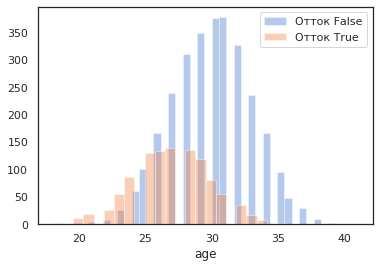

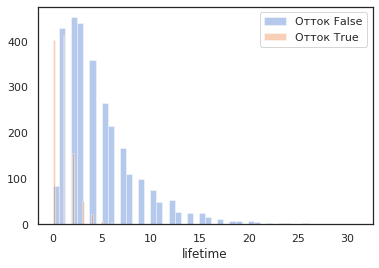

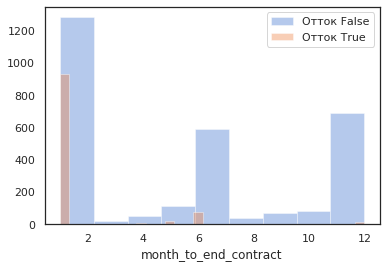

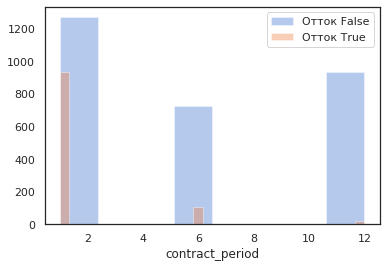

In [116]:
#для увчественной визуализации при построении графиков разделим признаки на дискретные, непрерывные и булевые

continuous = ['avg_additional_charges_total','avg_class_frequency_current_month', 'avg_class_frequency_total']
discrete = ['age','lifetime','month_to_end_contract','contract_period']
boolean = ['gender', 'group_visits', 'partner','near_location', 'promo_friends', 'phone']
 

for column in discrete:
    for churn in range(0, 2):
        sns.set(style="white", palette="muted")
        ax = sns.distplot(gym_churn.query('churn == @churn')[column],
                          kde=False,
                          label=('Отток {}'.format(bool(churn))))
        ax.legend()
    plt.show()

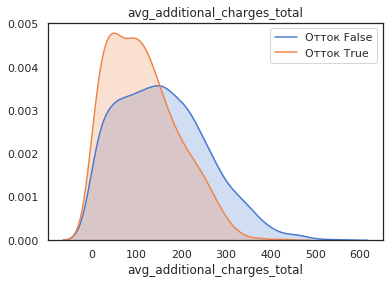

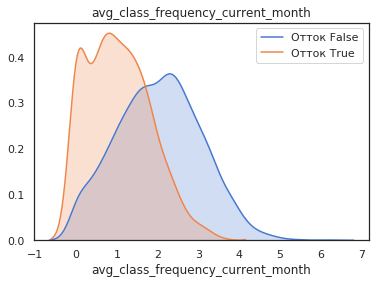

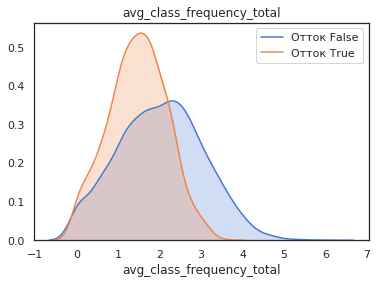

In [117]:
for column in continuous:
    for churn in range(0, 2):
        sns.set(style="white", palette="muted")
        ax = sns.distplot(gym_churn.query('churn == @churn')[column], hist=False, kde_kws={"shade": True},
                         label=('Отток {}'.format(bool(churn))))
        ax.legend()
        plt.title(column)

    plt.show()

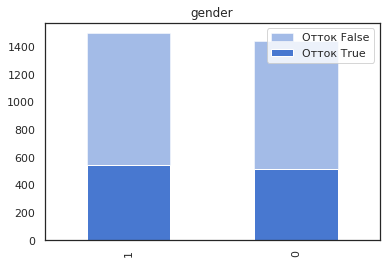

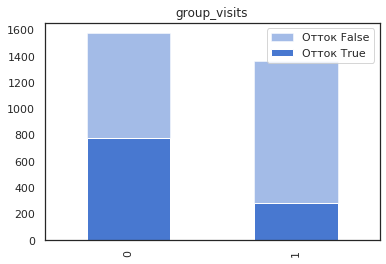

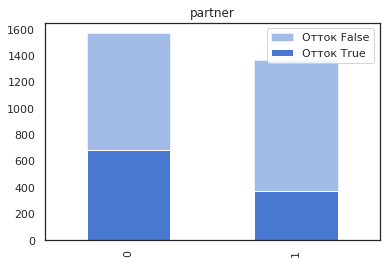

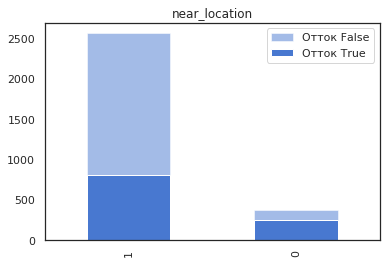

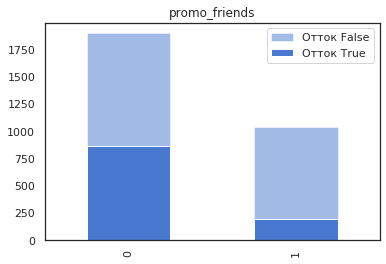

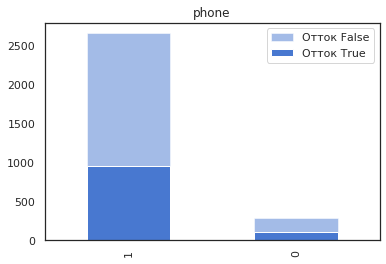

In [118]:
for column in boolean:
    for churn in range(0, 2):
        ax = gym_churn.query('churn == @churn')[column].value_counts().plot(
            kind='bar',alpha=(churn+1)/2, label=('Отток {}'.format(bool(churn))))
        plt.title(column)
        ax.legend()
    plt.show()

В принципе графики подтвердили, то что ранее было определено по средним значениям

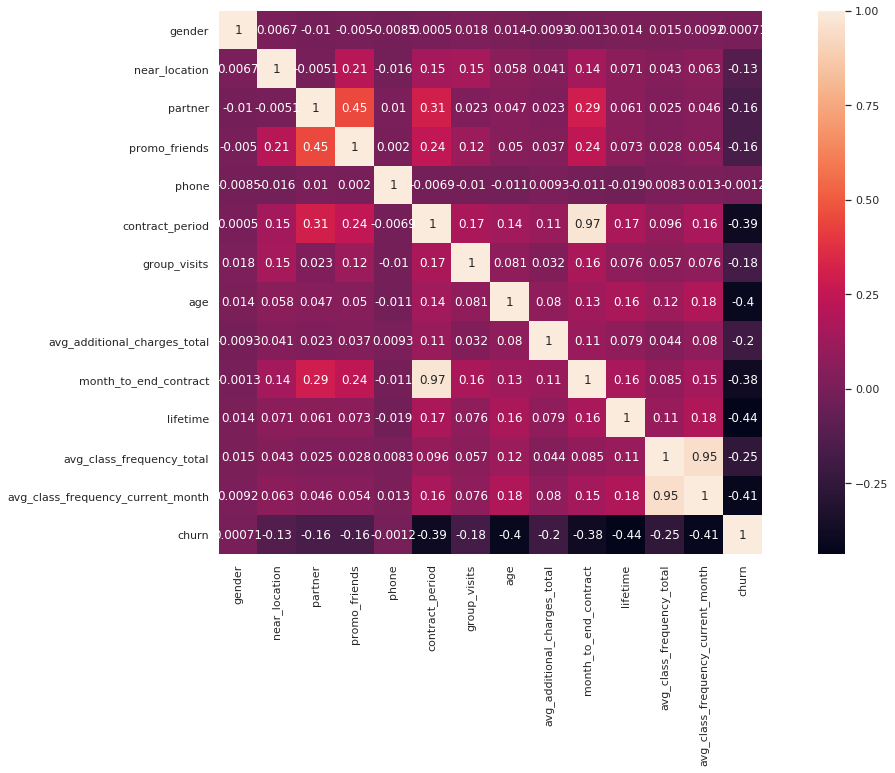

In [119]:
#посмотрим на матрицу корреляций
plt.figure(figsize=(20, 10))
cm = gym_churn.corr()
sns.heatmap(cm, annot=True, square=True)

Наблюдается сильная зависимость между сроком абонемента и временем до конца абонемента, а также посещением занаятий последнего месяца и общим посещением занятий.

Целевая переменная имеет высокую корреляцию с lifelime,age, и частотой посещения в последний месяц.

## Шаг 3. Построим модель для прогнозирования оттока.

Для задач бинарной классификации обучения с учителем подходят алгоритмы из библиотеки sklern: LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier.
<br>В рамках проекта воспользуемся моделями LogisticRegression и RandomForestClassifier

In [120]:
#разделим датасет на признаки (матрица X) и целевую переменную (вектор y)
X = gym_churn.drop(columns='churn')
y = gym_churn['churn']

# случайным образом разделим выборки на обучающую и валидационную
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=26)

#список используемых моделей
models = {
    'LogisticRegression': LogisticRegression(random_state=26),
    'RandomForestClassifier': RandomForestClassifier(random_state=26)
}

#для проверки качества модели воспользуемся метриками accuracy_score,precision_score,recall_score
metrics = {
    'Accuracy': accuracy_score,
    'Precission': precision_score,
    'Recall': recall_score
}

for name, model in models.items():
    m = model
    m.fit(X_train, y_train)
    prediction = m.predict(X_test)
    print('______________________________{}__________________________________'.
          format(name))
    for k, metric in metrics.items():
        print('Метрика {} равна = {:.2%}'.format(k, metric(y_test,
                                                           prediction)))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


______________________________LogisticRegression__________________________________
Метрика Accuracy равна = 94.50%
Метрика Precission равна = 94.68%
Метрика Recall равна = 83.96%
______________________________RandomForestClassifier__________________________________
Метрика Accuracy равна = 91.75%
Метрика Precission равна = 88.83%
Метрика Recall равна = 78.77%


Метрики модели LogisticRegression показывают результаты лучше чем RandomForestClassifier

## Шаг 4. Кластеризация пользователей

In [121]:
#стандартизируем признаки
scaler = StandardScaler()

data_sc = scaler.fit_transform(X)

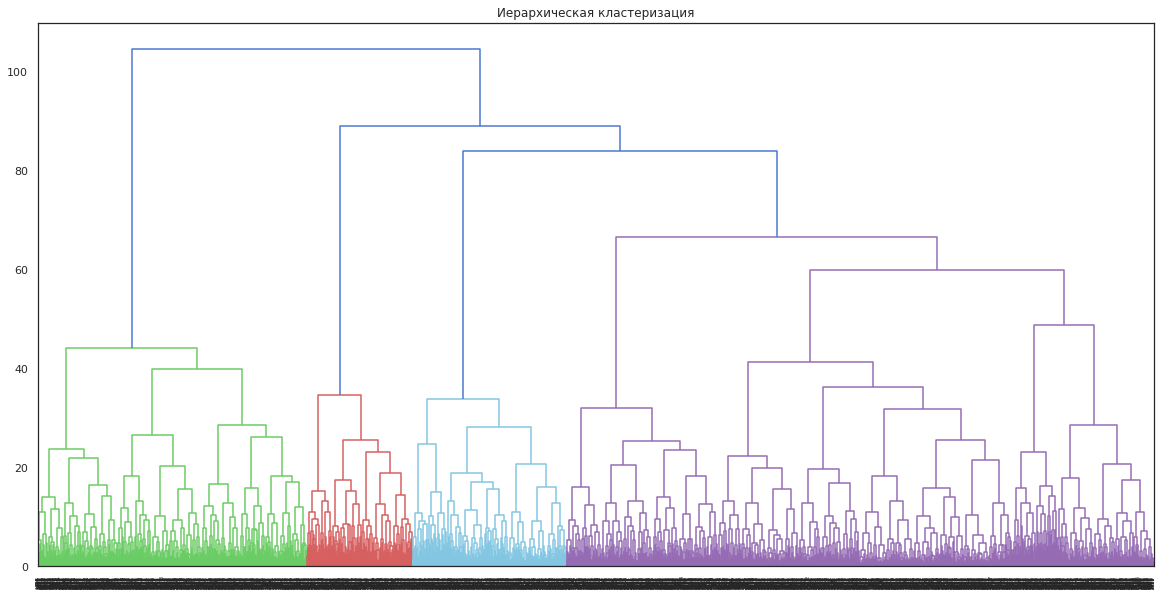

In [122]:
#нарисуем дендрограмму
linked = linkage(data_sc, method='ward')

plt.figure(figsize=(20, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

#### Исходя из дендограммы, можно предположить, что в нашей выборке 4 основных кластера.

In [123]:
#Обучим модель кластеризации на основании алгоритма K-Means
km = KMeans(n_clusters=5, random_state=26)
gym_churn['clusters_km'] = km.fit_predict(data_sc)

In [124]:
#посмотрим на средние данные по кластерам
gym_churn.groupby('clusters_km').mean().sort_values(by='churn')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
clusters_km,,,,,,,,,,,,,,
4,0.501068,0.944444,0.741453,0.489316,0.900641,11.878205,0.552350,29.913462,164.843651,10.869658,4.705128,1.991983,1.983475,0.022436
3,0.593085,0.972074,0.281915,0.117021,0.894947,2.909574,0.484043,30.319149,162.953822,2.666223,5.180851,2.924785,2.929752,0.057181
0,0.485804,1.000000,0.805994,1.000000,0.908517,3.102524,0.451104,29.078864,140.097349,2.881703,3.610410,1.682177,1.565955,0.263407
1,0.494505,0.000000,0.465201,0.076923,0.915751,2.225275,0.214286,28.478022,134.126172,2.089744,2.805861,1.659607,1.469327,0.448718
2,0.484099,1.000000,0.243816,0.010601,0.902827,1.976148,0.322438,28.227032,131.524179,1.893993,2.454064,1.306977,1.071938,0.516784


Исходя из проведенной кластеризации можно примерно составить портрет клиента с повышенной вероятностью оттока. Количество посещений снижается в последнем месяце отнсительно общего срднего кол-ва посещений. Чем короче lifetime, тем выше вероятность оттока. Вероятность оттока тем выше, чем меньше срок до окончания абонемента. No churn клиенты чаще посещают групповые занятия. 

Кластеры 4 и 3 менее всего подвержены оттоку, при этом у этих кластеров большая (в 4 раза) разница в сроке до окончания абонемента. У 3 кластера самая высокая посещаемость (в стреднем 3 дня, против 2 дней у 4 кластера).

Кластеры 0,1, 2 имеют повышенную вероятность оттока, при этом у 2 кластера вероятность оттока самая высокая и достигает 52%. Основные отличия этих кластеров: 100% кластера 0 пришли по промо друзей, у других двух групп этот параметр не превышает 10%. Чем ниже lifetime кластера, тем выше вероятность оттока. У кластера 2 самое высокое снижение посещаемости в последнем месяце - 18%.

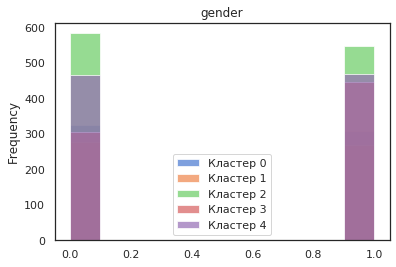

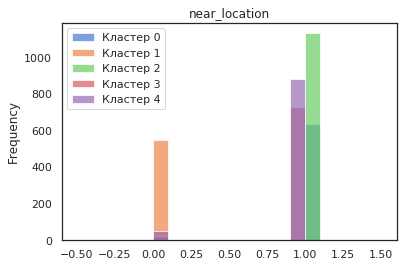

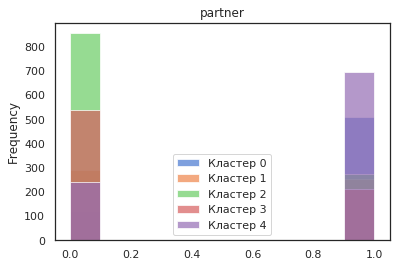

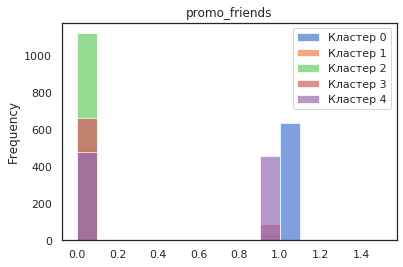

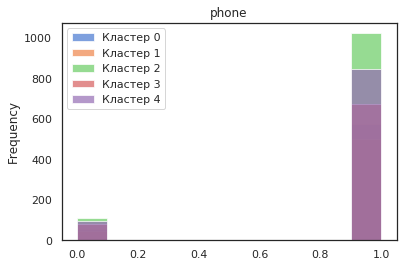

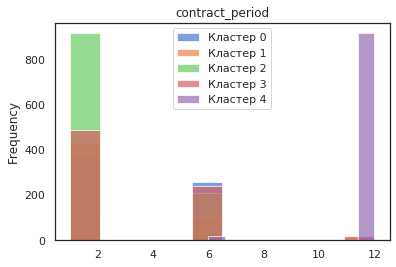

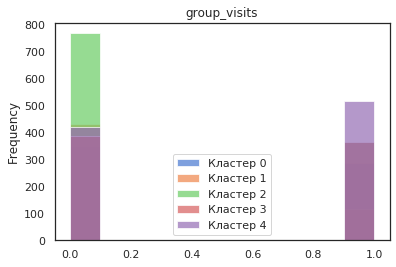

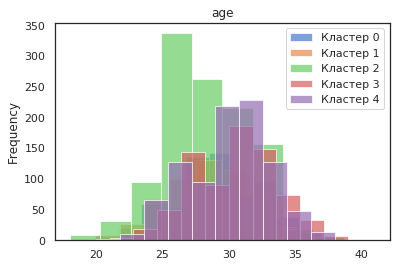

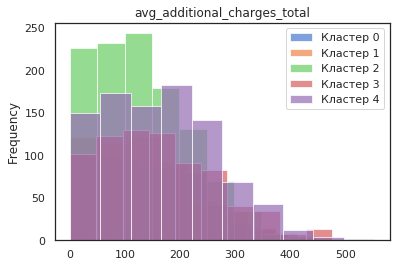

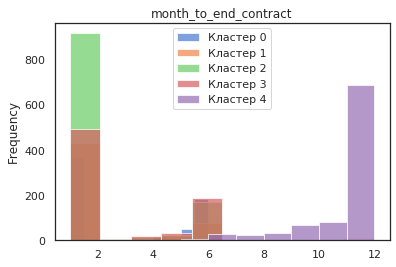

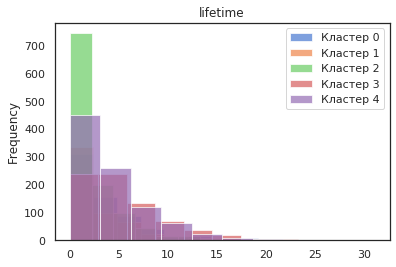

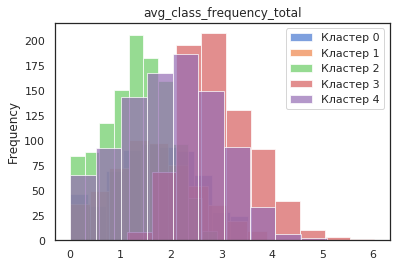

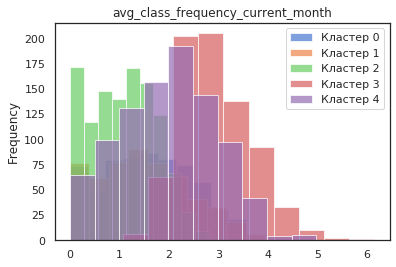

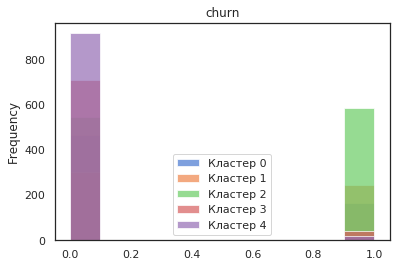

In [127]:
for column in gym_churn.drop(columns=['clusters_km']).columns:
    for cluster in range(0, 5):
        ax = gym_churn.query('clusters_km == @cluster')[column].plot(
            kind='hist', alpha = 0.7, label=('Кластер {}'.format(cluster)))
        plt.title(column)
        ax.legend()
    plt.show()

## Шаг 5. Выводы и базовые рекомендации по работе с клиентами

1. В предоставленных данных пол распределен примерно поровну, в основном клиенты выбирают зал рядом с домом, чуть меньше половины приходят по партнёрской программе. Около 31% были приведены другом, почти все оставили свой телефон, среднее время абонемента - около 5 месяцев, немногим меньше половины посещают групповые занятия. Срений возраст - 30 лет. В среднем клиенты начали посещать зал 4 месяца назад. Больше 70% данных собраны по текущим клиентам (no churn).
2. В данных есть мультиколинеарность. Высокая корреляция между сроком абонемента и временем до его окончания, а также средней посещаемостью всего и в последний месяц наблюдения.
3. Между моделями LogisticRegression и RandomForestClassifier, лучшей предсказательной силой, на основе метрик accuracy,precision,recall обладает алгоритм LogisticRegression.
4. На основании дендограммы можно предположить, что в датасете представлены данные, которые можно разделить на 4 основных класстера.
5. Исходя из проведенной кластеризации можно примерно составить портрет клиента с повышенной вероятностью оттока. Количество посещений снижается в последнем месяце отнсительно общего срднего кол-ва посещений. Чем короче lifetime, тем выше вероятность оттока. Вероятность оттока тем выше, чем меньше срок до окончания абонемента. No churn клиенты чаще посещают групповые занятия. Кластеры 0 и 4 менее всего подвержены оттоку, при этом у этих класстеров большая разница в сроке до окончания абонемента.

<br><b>Рекомендации по работе с клиентами: </b>
1. No churn чаще приходят по партнерской программе или программе друзей поэтому можно давать за привод друга 3 месяца бесплатно, и один отбирать, если друг отвалился в первые 2.
2. No churn имеют более длинные сроки абонемента, возможно имеет смысл предлагать бОльшие скидки на абонемент до 6 мес (lifetime no churn превышает 4 мес).
3. Churn клиенты меньше посещают зал, возможно при такой нагрузке они не наблюдают желаемого эффекта и быстро сдаются, перестав ходить - возможно имеет смысл на первые месяц -два выделить бесплатного инструктора, который будет контролировать посещаемость и эффективность тренировок.
4. При снижении посещаемости относительно средней, стоит обсудить с клиентом чем это вызвано, и простимулировать его вернуться в прежний график.
